In [ ]:
# 디렉터리 삭제
import shutil

shutil.rmtree(f'/content/flood4')
shutil.rmtree(f'/content/non_flood4')

FileNotFoundError: ignored

In [ ]:
!unzip /content/drive/MyDrive/PBL/flooding/dataset/flood_dataset5.zip -d ../content/flood_dataset5

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.2fbc87161ce64168dfd0ed63812cb23f.jpg  
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.4ac727fac3fce00ad72c1f60e88d9166.jpg  
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.bf5cd15d8fd18515d5b23bd6c0f7c753.jpg  
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.cff28b50603978bba5c5b31da61e6ff5.jpg  
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.eeaa1267f51af659314e6bde756362cc.jpg  
  inflating: ../content/flood_dataset5/flood4/00024_jpg.rf.fa15205c5a66c499d4a817b87c01ff4c.jpg  
  inflating: ../content/flood_dataset5/flood4/00025_jpg.rf.4389721782bf1c9744d8113cf0c94a38.jpg  
  inflating: ../content/flood_dataset5/flood4/00025_jpg.rf.5e61b71842002f05176d7bf17595ecb2.jpg  
  inflating: ../content/flood_dataset5/flood4/00025_jpg.rf.67412dca94a20519c49b5de905d69d26.jpg  
  inflating: ../content/flood_dataset5/flood4/00025_jpg.rf.adc0a505d342ff492ee4356

In [ ]:
# 이미지 처리와 시각 처리를 위한 도구
import numpy as np # 다차원 배열과 행렬 연산
import os # 운영체제
import cv2 # OpenCV 라이브러리
import matplotlib.pyplot as plt # Matplotlib 라이브러리, 데이터 시각화 라이브러리, 그래프 및 도표 생성
%matplotlib inline

In [ ]:
flood_images_path = r"../content/flood_dataset5/flood4"
non_flood_images_path = r"../content/flood_dataset5/non_flood4"

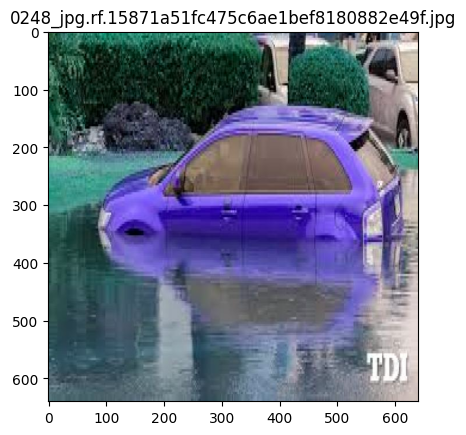

In [ ]:
# 침수 이미지 표시
for img in os.listdir(flood_images_path):# 화재 데이터셋 가져오기
    img_array = cv2.imread(os.path.join(flood_images_path,img)) # 화재 이미지 opencv로 읽어서 img_array에 저장
    plt.imshow(img_array) # img_array에 저장된 이미지 표시
    plt.title(img)  # 이미지 위에 파일 이름을 출력
    plt.show() # 화면에 이미지 출력
    break # 맨 처음 이미지 출력하고 종료, 이거 제거하면 여러 이미지 출력 가능

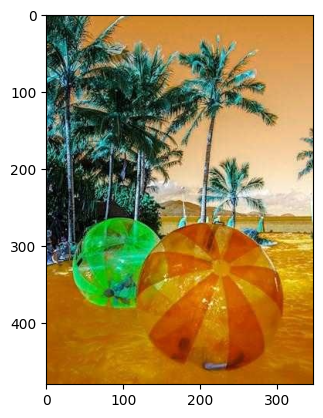

In [ ]:
# 비침수 이미지 표시
for img in os.listdir(non_flood_images_path):
    img_array = cv2.imread(os.path.join(non_flood_images_path,img))
    plt.imshow(img_array)
    plt.show()
    break

In [ ]:
# img_array의 형태 표시, 이미지 크기와 색상 채널 수 표시
img_array.shape # (높이, 너비, 채널) 튜플 반환, 채널이 3이면 컬러, 1이면 흑백

(480, 347, 3)

In [ ]:
# 이미지 데이터 전처리
data = [] # 이미지 데이터와 클래스 레이블을 저장할 리스트 선언
IMG_SIZE = 32 # 모든 이미지 32x32 픽셀로 조정

def get_data(file_path,class_num, data): # 이미지 데이터 data에 저장
    for img in os.listdir(file_path):
        try:
            img_array = cv2.imread(os.path.join(file_path,img)) # 이미지 파일 경로 저장, 파일을 img_array에 저장
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # 이미지 크기 리사이징
            data.append([new_array, class_num]) # 이미지와 클래스 레이블 엮서서 data 리스트에 추가
        except:
            pass # 예외 무시하고 처리
get_data(flood_images_path,1,data) # 1이면 침수 이미지
get_data(non_flood_images_path,0,data) # 0이면 비침수 이미지

In [ ]:
# data 리스트의 개수 반환
len(data)

5151

In [ ]:
# 텐서플로우 모델 정의
import tensorflow as tf # 텐서플로우 라이브러리 가져오기
from tensorflow import keras # 텐서플로우의 케라스 모듈 가져오기
from tensorflow.keras import layers, models # 케라스에서 서브 모듈인 layers, models 가져오기
from keras.layers import Dense, Activation, Flatten, Dropout # 순서대로 연결레이어, 활성화함수, 배열평탄화, 과적합방지

In [ ]:
# 데이터 증강으로 이미지 데이터셋 확장 (텐서플로우 이용)
data_augmentation1 = tf.keras.Sequential([  # 데이터 증강 파이프라인 정의 1
  layers.experimental.preprocessing.RandomZoom(0.5), # 이미지의 0~50% 범위에서 무작위로 줌 적용
])

data_augmentation2 = tf.keras.Sequential([ # 데이터 증강 파이프라인 정의 2
  layers.experimental.preprocessing.RandomContrast(0.2) # 이미지의 대비를 무작위로 조정
])

def apply_augmentation(data): # 데이터 증강 함수
    flood_count = sum(1 for _, label in data if label == 1) # 침수 이미지의 개수 계산
    non_flood_count = sum(1 for _, label in data if label == 0) # 비침수 이미지의 개수 계산

    while non_flood_count < flood_count: # 비침수 이미지 수가 침수 이미지 수와 같아질 때까지 반복
        for i in range(len(data)):
            if data[i][1] == 0: # 데이터 레이블이 0, 즉 비침수 이미지에만 데이터 증강 수행
                data.append([data_augmentation1(data[i][0]), 0]) # 변형된 추가 데이터 생성
                non_flood_count += 1 # 비침수 이미지 개수 증가
                if non_flood_count >= flood_count: # 비침수 이미지 수가 침수 이미지 수와 같거나 크면 반복 종료
                    break

apply_augmentation(data) # 변형해서 확장된 데이터셋을 원래 데이터와 함께 data 리스트에 추가

# 침수 이미지 수와 비침수 이미지 수 출력
flood_count = sum(1 for _, label in data if label == 1)
non_flood_count = sum(1 for _, label in data if label == 0)
print("침수 이미지 수:", flood_count)
print("비침수 이미지 수:", non_flood_count)

len(data) # 전체 데이터셋 크기 확인

침수 이미지 수: 2800
비침수 이미지 수: 2800


5600

In [ ]:
# 데이터 증강으로 이미지 데이터셋 확장 (텐서플로우 이용)
data_augmentation1 = tf.keras.Sequential([  # 데이터 증강 파이프라인 정의 1
  layers.experimental.preprocessing.RandomZoom(0.5), # 이미지의 0~50% 범위에서 무작위로 줌 적용
])

data_augmentation2 = tf.keras.Sequential([ # 데이터 증강 파이프라인 정의 2
  layers.experimental.preprocessing.RandomContrast(0.2) # 이미지의 대비를 무작위로 조정
])

def apply_augmentation(data): # 데이터 증강 함수
    for i in range(len(data)):
        if data[i][1] == 0 or data[i][1] == 1:
            data.append([data_augmentation1(data[i][0]), data[i][1]])  # 변형된 추가 데이터 생성
            data.append([data_augmentation2(data[i][0]), data[i][1]])  # 변형된 추가 데이터 생성
apply_augmentation(data) # 변형해서 확장된 데이터셋을 원래 데이터와 함께 data 리스트에 추가
len(data) # 데이터셋 크기 확인

16800

In [ ]:
# 데이터셋 섞기
import random
random.shuffle(data) # 데이터셋 랜덤으로 섞기 (모델 학습 시에 데이터 순서에 영향 안 받게 함)

In [ ]:
# 이미지 데이터와 클래스 레이블 분리 (데이터셋 준비 과정)
X = [] # 이미지 데이터 저장 리스트
y = [] # 이미지의 클래스 레이블 저장 리스트

for i in data:
    X.append(i[0]) # i[0]이 데이터의 첫 번째 요소로 이미지 데이터
    y.append(i[1]) # i[1]이 데이터의 두 번재 요소로 클래스 레이블

In [ ]:
# 데이터셋에서 이미지, 클래스 레이블 확인
X[0],y[0]

(<tf.Tensor: shape=(32, 32, 3), dtype=float32, numpy=
 array([[[114.702415, 126.18083 , 130.6112  ],
         [117.89948 , 129.3779  , 133.80827 ],
         [118.965164, 129.3779  , 137.00534 ],
         ...,
         [140.27893 , 149.62598 , 152.99066 ],
         [139.21324 , 152.82304 , 155.12204 ],
         [138.14755 , 151.75735 , 154.05635 ]],
 
        [[113.63673 , 125.11514 , 129.54552 ],
         [117.89948 , 129.3779  , 133.80827 ],
         [120.03085 , 130.44359 , 138.07103 ],
         ...,
         [110.43966 , 126.18083 , 128.47983 ],
         [106.17691 , 122.98377 , 129.54552 ],
         [102.97984 , 119.786705, 126.34846 ]],
 
        [[120.03085 , 129.3779  , 133.80827 ],
         [120.03085 , 129.3779  , 133.80827 ],
         [116.83379 , 126.18083 , 129.54552 ],
         ...,
         [ 56.08957 ,  72.89642 ,  79.458176],
         [ 63.549385,  76.09349 ,  82.65524 ],
         [ 63.549385,  80.35625 ,  87.98368 ]],
 
        ...,
 
        [[130.68774 , 134.70634 , 

(array([8400.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        8400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

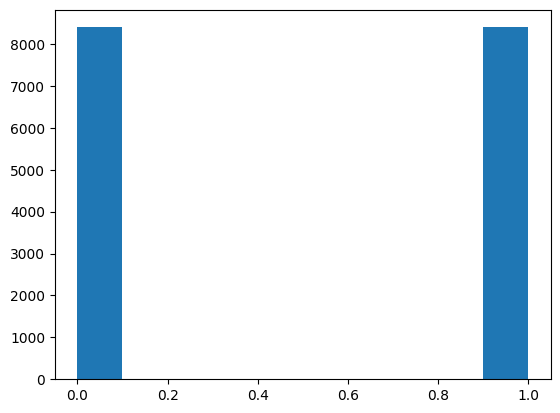

In [ ]:
# 클래스 레이블 데이터 시각화
plt.hist(y)

In [ ]:
# 이미지 데이터 형태 조정, X랑 y 리스트 각각 배열 변환
X = np.array(X).reshape(-1,IMG_SIZE, IMG_SIZE,3) # 4차원 배열로 변환
y = np.array(y) # 1차원 배열로 변환

In [ ]:
# 배열 X와 y 형태 변환
X.shape, y.shape
# X는 (데이터 개수, 높이, 너비, 채널 수), y는 (클래스 레이블 개수, )

((16800, 32, 32, 3), (16800,))

In [ ]:
# 데이터셋을 학습 용과 테스트 용으로 나누기
from sklearn.model_selection import train_test_split

# 데이터 X와 레이블 y를 학습 셋과 테스트 셋으로 나눔, 테스트 셋은 20%
# 테스트 셋을 검증 셋과 최종 테스트 셋으로 나눔
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2)
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5)

In [ ]:
# 데이터셋 형태 출력
print(X_train.shape) # 학습 세트의 형태 출력 (데이터 수, 이미지 높이, 너비, 채널 수)
print(X_test.shape) # 테스트 세트의 형태 출력
print(X_val.shape) # 검증 세트의 형태 출력

(13440, 32, 32, 3)
(1680, 32, 32, 3)
(1680, 32, 32, 3)


In [ ]:
# 텐서플로우로 모델 정의
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dense, Activation, Flatten, Dropout

In [ ]:
# 모델 분류
model = models.Sequential([ # 순차적으로 레이어를 쌓아가는 Keras의 모델
  # 첫 번째 합성곱 레이어 (Conv2D), 입력 이미지의 특징 추출
  # 'padding'은 'same'으로 설정되어 입력과 출력 크기 동일하게 유지
  layers.Conv2D(32, kernel_size = (3,3), padding='same', activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,3)),
  # 첫 번째 맥스 풀링 레이어 (MaxPooling2D)
  # 공간 크기 감소 및 계산 비용을 위해 사용
  layers.MaxPooling2D(),

  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Dropout(0.5), # 드롭 아웃 레이어

  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, kernel_size = (3,3), padding='same', activation='relu'),
  layers.MaxPooling2D(),

  # 최종 분류 수행
  layers.Flatten(), # 다차원 배열을 1차원 배열로 변환
  layers.Dense(60, activation='relu'),  # 첫 번째 Fully Connected 레이어 (Dense), 모든 뉴런이 이전 레이어의 모든 뉴런과 연결
  layers.Dropout(0.5), # 드롭 아웃 레이어
  layers.Dense(1, activation='sigmoid') # 두 번째 Fully Connected 레이어 (Dense), 이진 분류 문제에서 출력을 생성
])

In [ ]:
# 모델 구조 출력
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)         

In [ ]:
# 모델 컴파일
from tensorflow.keras.optimizers import Adam

custom_optimizer = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])
# binary_crossentropy는 이진 분류에서 사용되는 손실 함수
# Adam 최적화 알고리즘 사용, 학습률을 자동으로 조절하여 모델의 학습을 최적화
# 'accuracy'를 설정하여 정확도를 성능 평가 지표로 사용, 모델이 올바르게 분류한 이미지의 비율

In [ ]:
# 모델 훈련, epochs는 반복하는 학습 횟수 에폭
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40) # train은 훈련 데이터, validation은 검증 데이터

Epoch 1/40
420/420 [==============================] - 32s 73ms/step - loss: 0.8033 - accuracy: 0.7202 - val_loss: 0.3309 - val_accuracy: 0.8750
Epoch 2/40
420/420 [==============================] - 30s 72ms/step - loss: 0.3581 - accuracy: 0.8604 - val_loss: 0.2902 - val_accuracy: 0.8738
Epoch 3/40
420/420 [==============================] - 27s 64ms/step - loss: 0.3166 - accuracy: 0.8824 - val_loss: 0.3105 - val_accuracy: 0.8881
Epoch 4/40
420/420 [==============================] - 32s 75ms/step - loss: 0.2939 - accuracy: 0.8872 - val_loss: 0.2496 - val_accuracy: 0.9018
Epoch 5/40
420/420 [==============================] - 31s 73ms/step - loss: 0.2742 - accuracy: 0.9004 - val_loss: 0.2467 - val_accuracy: 0.9119
Epoch 6/40
420/420 [==============================] - 29s 68ms/step - loss: 0.2639 - accuracy: 0.9028 - val_loss: 0.2697 - val_accuracy: 0.8923
Epoch 7/40
420/420 [==============================] - 28s 67ms/step - loss: 0.2582 - accuracy: 0.9092 - val_loss: 0.2430 - val_accuracy:

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

# k-fold 교차 검증을 위한 객체 생성
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# k-fold 교차 검증을 위한 데이터 분할 및 모델 학습
cv_accuracy = []
cv_loss = []
n_iter = 0

for train_index, test_index in kfold.split(X_train, y_train):
    # 학습 데이터와 검증 데이터 분할
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # 모델 생성 및 컴파일
    model = models.Sequential([
        layers.Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D(),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.5),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(60, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    custom_optimizer = Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy', optimizer=custom_optimizer, metrics=['accuracy'])

    # 모델 훈련
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=30)

    # 검증 데이터로 정확도 측정
    accuracy = np.round(history.history['val_accuracy'][-1], 4)
    loss = np.round(history.history['val_loss'][-1], 4)
    train_size = X_train_fold.shape[0]
    val_size = X_val_fold.shape[0]
    print(f"\n#{n_iter+1} 교차 검증 정확도: {accuracy}, 학습 데이터 크기: {train_size}, 검증 데이터 크기: {val_size}")
    print(f"#{n_iter+1} 검증 세트 인덱스: {test_index}")

    cv_accuracy.append(accuracy)
    cv_loss.append(loss)
    n_iter += 1

# 평균 검증 정확도 계산
print(f"\n## 평균 검증 정확도: {np.mean(cv_accuracy)}")
print(f"평균 검증 손실: {np.mean(cv_loss)}")

Epoch 1/30
336/336 [==============================] - 24s 69ms/step - loss: 0.7583 - accuracy: 0.7517 - val_loss: 0.3550 - val_accuracy: 0.8627
Epoch 2/30
336/336 [==============================] - 27s 79ms/step - loss: 0.3579 - accuracy: 0.8618 - val_loss: 0.3049 - val_accuracy: 0.8836
Epoch 3/30
336/336 [==============================] - 24s 72ms/step - loss: 0.3216 - accuracy: 0.8806 - val_loss: 0.2569 - val_accuracy: 0.8977
Epoch 4/30
336/336 [==============================] - 26s 77ms/step - loss: 0.3022 - accuracy: 0.8882 - val_loss: 0.2713 - val_accuracy: 0.9044
Epoch 5/30
336/336 [==============================] - 24s 70ms/step - loss: 0.2877 - accuracy: 0.8935 - val_loss: 0.2522 - val_accuracy: 0.9029
Epoch 6/30
336/336 [==============================] - 24s 72ms/step - loss: 0.2789 - accuracy: 0.8952 - val_loss: 0.2399 - val_accuracy: 0.9066
Epoch 7/30
336/336 [==============================] - 25s 74ms/step - loss: 0.2616 - accuracy: 0.9082 - val_loss: 0.2339 - val_accuracy:

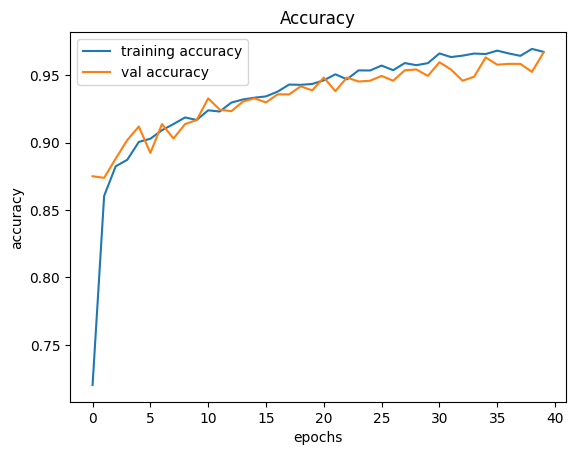

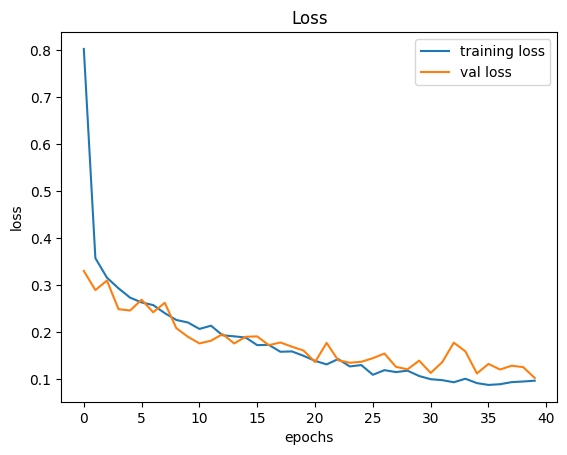

In [ ]:
# 정확도 함수
plt.figure(0) # 그래프 창 생성
plt.plot(history.history['accuracy'], label='training accuracy') # 학습 정확도 라벨 붙여서 표시
plt.plot(history.history['val_accuracy'], label='val accuracy') # 검증 정확도 라벨 붙여서 표시
plt.title("Accuracy") # 그래프 제목 설정
plt.xlabel('epochs') # x축 레이블을 학습 수로 설정
plt.ylabel('accuracy') # y축 레이블을 정확도로 설정
plt.legend() # 그래프에 범례 추가
plt.show() # 화면에 그래프 표시

# 손실 함수 (오차 함수)
plt.figure(1) # 그래프 창 생성
plt.plot(history.history['loss'], label='training loss') # 손실
plt.plot(history.history['val_loss'], label='val loss') # 검증 손실
plt.title('Loss') # 그래프 제목 설정
plt.xlabel('epochs') # x축 레이블을 학습 수로 설정
plt.ylabel('loss') # y축 레이블을 손실로 설정
plt.legend() # 그래프에 범례 추가
plt.show() # 화면에 그래프 표시

In [ ]:
# 모델 저장
model.save("/content/drive/MyDrive/PBL/RealFloodCrossModel")

In [ ]:
# 모델 저장 확인
file_path = "/content/drive/MyDrive/PBL/RealFloodCrossModel"

if os.path.exists(file_path):
    print(f"{file_path} 파일이 존재합니다.")
else:
    print(f"{file_path} 파일이 존재하지 않습니다.")

/content/drive/MyDrive/PBL/RealFloodCrossModel 파일이 존재합니다.


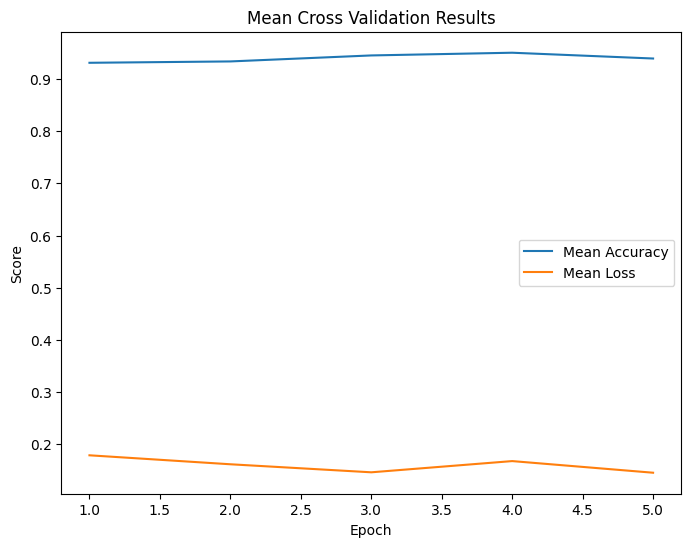

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 평균 검증 정확도와 평균 검증 손실 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cv_accuracy)+1), cv_accuracy, label='Mean Accuracy')
plt.plot(range(1, len(cv_loss)+1), cv_loss, label='Mean Loss')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Mean Cross Validation Results')
plt.legend()
plt.show()

53/53 [==============================] - 3s 43ms/step


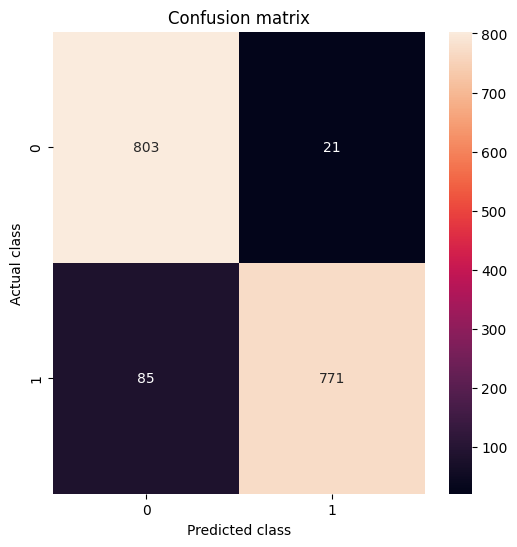

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 새로운 데이터에 대한 예측 생성
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

# 혼동 행렬 생성
cm = confusion_matrix(y_test, y_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual class')
plt.xlabel('Predicted class')
plt.show()

53/53 [==============================] - 2s 28ms/step
정밀도: 0.9735, 재현율: 0.9007, F1 스코어: 0.9357


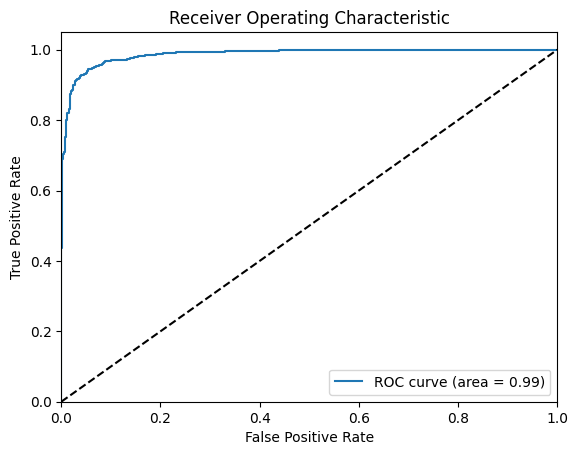

AUC 스코어: 0.9867


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

# 테스트 데이터에 대한 예측 생성
y_pred = model.predict(X_test)
y_pred_round = np.round(y_pred)

# 정밀도, 재현율, F1 스코어 계산
precision = precision_score(y_test, y_pred_round)
recall = recall_score(y_test, y_pred_round)
f1 = f1_score(y_test, y_pred_round)

print(f"정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1 스코어: {f1:.4f}")

# ROC 곡선 그리기 및 AUC 계산
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f"AUC 스코어: {roc_auc:.4f}")

Text(40, 0.9666666388511658, 'Validation Accuracy: 0.9667')

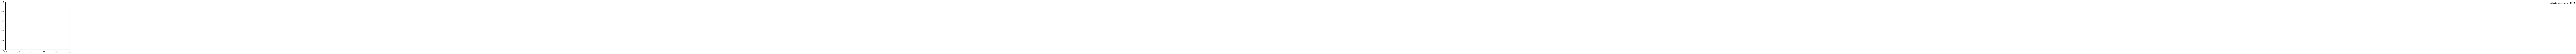

In [ ]:
# 정확도 값 텍스트로 출력
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
plt.text(len(history.history['accuracy']), final_train_accuracy, f'Training Accuracy: {final_train_accuracy:.4f}', ha='right')
plt.text(len(history.history['val_accuracy']), final_val_accuracy, f'Validation Accuracy: {final_val_accuracy:.4f}', ha='right')

In [ ]:
# 모델 평가
model.evaluate(X_test,y_test) # X_test를 입력, y_test는 테스트 데이터의 레이블

53/53 [==============================] - 2s 29ms/step - loss: 0.1201 - accuracy: 0.9643


[0.12009923905134201, 0.9642857313156128]

In [ ]:
# 테스트 데이터에 대한 예측 수행
predictions = model.predict(X_test)

53/53 [==============================] - 1s 25ms/step


In [ ]:
# 테스트 데이터에 대한 예측 결과 중 처음 5개 출력
predictions[:5]

array([[1.7505728e-01],
       [9.9574733e-01],
       [1.0000000e+00],
       [5.7055549e-05],
       [1.1619391e-04]], dtype=float32)

In [ ]:
# 모델의 예측 값을 0.5를 기준으로 이진 분류
predicted= []

for i in predictions:
    if i >0.5: # 예측 값이 0.5보다 크면
        predicted.append(1) # 1로 분류
    else:
        predicted.append(0)
predicted[:5]

[0, 1, 0, 0, 0]

In [ ]:
# 혼동 행렬 생성 (모델의 분류 성능 평가를 위해 사용)
cm = tf.math.confusion_matrix(labels=y_test,predictions=predicted)

<Axes: >

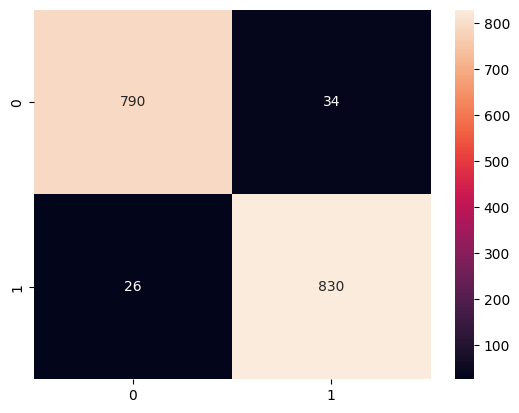

In [ ]:
# 혼동 행렬 시각화
import seaborn as sn

sn.heatmap(cm,annot=True, fmt='d')

In [ ]:
# 정밀도와 재현율 계산
true_positive = cm[1, 1]
false_positive = cm[0, 1]
false_negative = cm[1, 0]

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

# F1 스코어 계산
f1_score = 2 * (precision * recall) / (precision + recall)

print("정밀도:", precision)
print("재현율:", recall)
print("F1 스코어:", f1_score)

정밀도: tf.Tensor(0.9606481481481481, shape=(), dtype=float64)
재현율: tf.Tensor(0.969626168224299, shape=(), dtype=float64)
F1 스코어: tf.Tensor(0.9651162790697674, shape=(), dtype=float64)


53/53 [==============================] - 2s 29ms/step


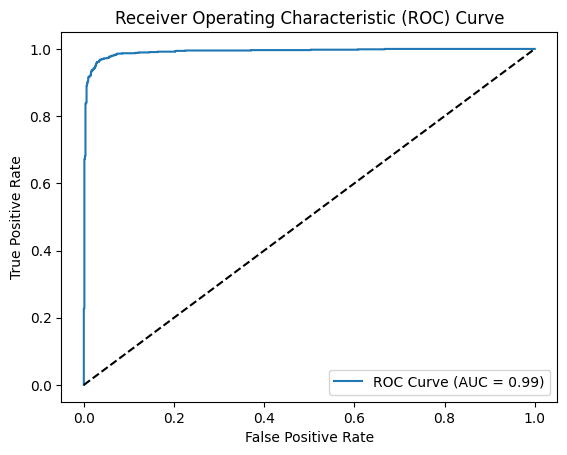

AUC 스코어: 0.9921251190908266


In [ ]:
from sklearn.metrics import roc_curve, auc

# 모델의 예측 확률을 얻어옵니다.
y_pred_prob = model.predict(X_test)

# 양성 클래스에 대한 예측 확률을 추출합니다.
y_pred_prob_positive = y_pred_prob.flatten()

# 실제 클ㅁ래스 레이블을 가져옵니다.
y_true = y_test

# ROC 곡선을 계산합니다.
fpr, tpr, _ = roc_curve(y_true, y_pred_prob_positive)

# AUC 스코어를 계산합니다.
auc_score = auc(fpr, tpr)

# ROC 곡선과 AUC 스코어를 출력합니다.
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')  # 랜덤 분류기의 선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("AUC 스코어:", auc_score)

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


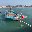

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


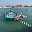

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


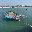

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


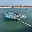

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


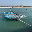

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


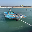

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


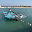

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


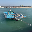

1/1 [==============================] - 0s 42ms/step
프레임 분류: no flood


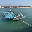

1/1 [==============================] - 0s 44ms/step
프레임 분류: no flood


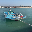

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


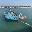

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


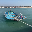

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


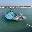

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


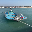

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


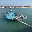

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


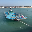

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


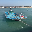

1/1 [==============================] - 0s 37ms/step
프레임 분류: no flood


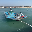

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


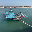

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


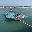

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


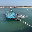

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


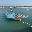

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


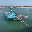

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


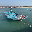

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


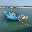

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


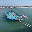

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


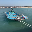

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


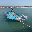

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


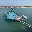

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


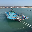

1/1 [==============================] - 0s 29ms/step
프레임 분류: no flood


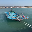

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


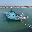

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


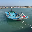

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


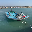

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


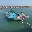

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


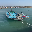

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


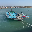

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


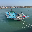

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


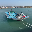

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


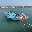

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


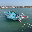

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


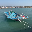

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


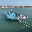

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


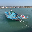

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


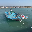

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


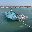

1/1 [==============================] - 0s 25ms/step
프레임 분류: no flood


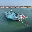

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


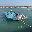

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


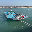

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


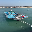

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


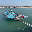

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


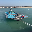

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


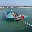

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


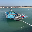

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


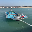

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


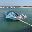

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


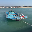

1/1 [==============================] - 0s 55ms/step
프레임 분류: no flood


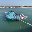

1/1 [==============================] - 0s 37ms/step
프레임 분류: no flood


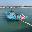

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


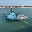

1/1 [==============================] - 0s 40ms/step
프레임 분류: no flood


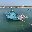

1/1 [==============================] - 0s 46ms/step
프레임 분류: no flood


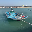

1/1 [==============================] - 0s 39ms/step
프레임 분류: no flood


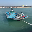

1/1 [==============================] - 0s 46ms/step
프레임 분류: no flood


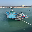

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


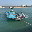

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


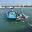

1/1 [==============================] - 0s 38ms/step
프레임 분류: no flood


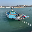

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


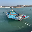

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


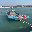

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


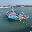

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


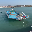

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


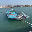

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


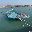

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


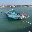

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


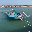

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


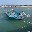

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


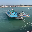

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


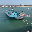

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


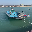

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


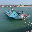

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


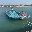

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


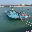

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


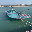

1/1 [==============================] - 0s 24ms/step
프레임 분류: no flood


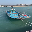

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


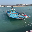

1/1 [==============================] - 0s 26ms/step
프레임 분류: no flood


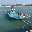

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


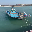

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


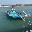

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


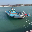

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


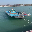

1/1 [==============================] - 0s 28ms/step
프레임 분류: no flood


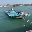

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


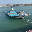

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


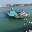

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


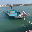

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


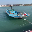

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


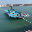

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


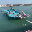

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


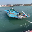

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


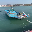

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


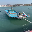

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


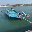

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


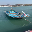

1/1 [==============================] - 0s 24ms/step
프레임 분류: no flood


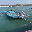

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


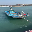

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


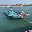

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


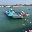

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


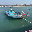

1/1 [==============================] - 0s 26ms/step
프레임 분류: no flood


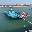

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


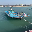

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


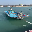

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


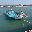

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


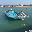

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


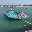

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


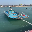

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


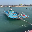

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


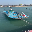

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


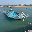

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


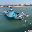

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


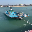

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


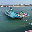

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


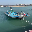

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


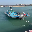

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


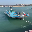

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


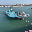

1/1 [==============================] - 0s 19ms/step
프레임 분류: no flood


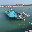

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


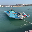

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


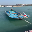

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


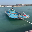

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


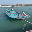

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


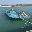

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


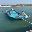

1/1 [==============================] - 0s 24ms/step
프레임 분류: no flood


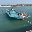

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


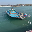

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


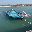

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


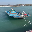

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


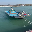

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


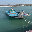

1/1 [==============================] - 0s 26ms/step
프레임 분류: no flood


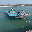

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


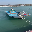

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


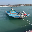

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


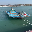

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


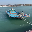

1/1 [==============================] - 0s 50ms/step
프레임 분류: no flood


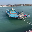

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


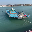

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


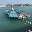

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


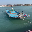

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


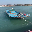

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


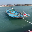

1/1 [==============================] - 0s 46ms/step
프레임 분류: no flood


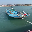

1/1 [==============================] - 0s 38ms/step
프레임 분류: no flood


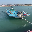

1/1 [==============================] - 0s 51ms/step
프레임 분류: no flood


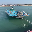

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


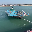

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


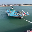

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


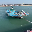

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


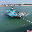

1/1 [==============================] - 0s 39ms/step
프레임 분류: no flood


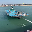

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


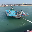

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


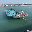

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


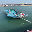

1/1 [==============================] - 0s 29ms/step
프레임 분류: no flood


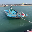

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


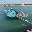

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


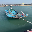

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


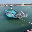

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


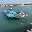

1/1 [==============================] - 0s 40ms/step
프레임 분류: no flood


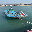

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


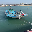

1/1 [==============================] - 0s 40ms/step
프레임 분류: no flood


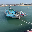

1/1 [==============================] - 0s 29ms/step
프레임 분류: no flood


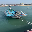

1/1 [==============================] - 0s 38ms/step
프레임 분류: no flood


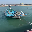

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


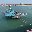

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


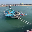

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


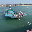

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


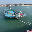

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


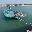

1/1 [==============================] - 0s 43ms/step
프레임 분류: no flood


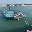

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


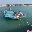

1/1 [==============================] - 0s 49ms/step
프레임 분류: no flood


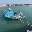

1/1 [==============================] - 0s 53ms/step
프레임 분류: no flood


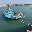

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


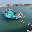

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


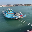

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


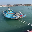

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


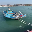

1/1 [==============================] - 0s 44ms/step
프레임 분류: no flood


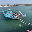

1/1 [==============================] - 0s 42ms/step
프레임 분류: no flood


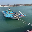

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


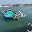

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


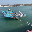

1/1 [==============================] - 0s 43ms/step
프레임 분류: no flood


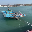

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


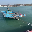

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


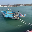

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


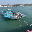

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


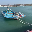

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


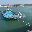

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


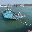

1/1 [==============================] - 0s 37ms/step
프레임 분류: no flood


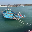

1/1 [==============================] - 0s 39ms/step
프레임 분류: no flood


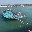

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


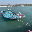

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


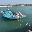

1/1 [==============================] - 0s 42ms/step
프레임 분류: no flood


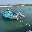

1/1 [==============================] - 0s 51ms/step
프레임 분류: no flood


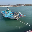

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


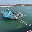

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


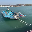

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


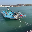

1/1 [==============================] - 0s 37ms/step
프레임 분류: no flood


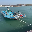

1/1 [==============================] - 0s 29ms/step
프레임 분류: no flood


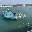

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


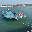

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


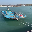

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


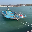

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


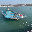

1/1 [==============================] - 0s 36ms/step
프레임 분류: no flood


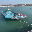

1/1 [==============================] - 0s 43ms/step
프레임 분류: no flood


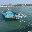

1/1 [==============================] - 0s 54ms/step
프레임 분류: no flood


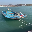

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


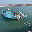

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


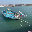

1/1 [==============================] - 0s 31ms/step
프레임 분류: no flood


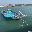

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


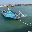

1/1 [==============================] - 0s 34ms/step
프레임 분류: no flood


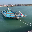

1/1 [==============================] - 0s 43ms/step
프레임 분류: no flood


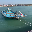

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


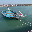

1/1 [==============================] - 0s 35ms/step
프레임 분류: no flood


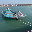

1/1 [==============================] - 0s 33ms/step
프레임 분류: no flood


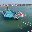

1/1 [==============================] - 0s 42ms/step
프레임 분류: no flood


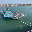

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


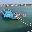

1/1 [==============================] - 0s 30ms/step
프레임 분류: no flood


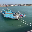

1/1 [==============================] - 0s 28ms/step
프레임 분류: no flood


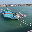

1/1 [==============================] - 0s 29ms/step
프레임 분류: no flood


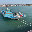

1/1 [==============================] - 0s 26ms/step
프레임 분류: no flood


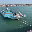

1/1 [==============================] - 0s 24ms/step
프레임 분류: no flood


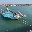

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


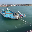

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


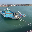

1/1 [==============================] - 0s 25ms/step
프레임 분류: no flood


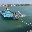

1/1 [==============================] - 0s 22ms/step
프레임 분류: no flood


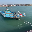

1/1 [==============================] - 0s 27ms/step
프레임 분류: no flood


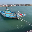

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


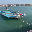

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


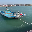

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


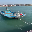

1/1 [==============================] - 0s 24ms/step
프레임 분류: no flood


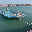

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


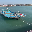

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


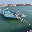

1/1 [==============================] - 0s 21ms/step
프레임 분류: no flood


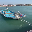

1/1 [==============================] - 0s 32ms/step
프레임 분류: no flood


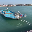

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


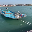

1/1 [==============================] - 0s 20ms/step
프레임 분류: no flood


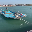

1/1 [==============================] - 0s 26ms/step
프레임 분류: no flood


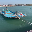

1/1 [==============================] - 0s 23ms/step
프레임 분류: no flood


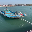

In [ ]:
from IPython.display import Image, display
import cv2
import numpy as np
import tensorflow as tf

# 비디오 파일 경로를 지정
video_path = '/content/drive/MyDrive/PBL/flooding/example/boat2.mp4'
# 비디오 파일 열기
cap = cv2.VideoCapture(video_path)

# 비디오 파일의 총 프레임 수 계산
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# 화재와 비화재 프레임의 개수 초기화
flood_frame_count = 0
non_flood_frame_count = 0

# 5프레임 단위로 처리하기 위한 변수 설정
frame_interval = 5
frame_counter = 0

while True:
    # 프레임을 읽어오기
    ret, frame = cap.read()

    if not ret:
        break  # 모든 프레임을 읽었으면 종료

    frame_counter += 1

    # 5프레임 단위로 프레임 처리
    if frame_counter % frame_interval == 1:
        # 프레임을 모델 입력 형식에 맞게 조정
        frame = cv2.resize(frame, (32, 32))
        frame = np.expand_dims(frame, axis=0)

        # 프레임을 모델에 입력하여 예측
        predictions = model.predict(frame)

        # 예측 결과 확인
        if predictions[0][0] > 0.5:
            result = "flood"
            flood_frame_count += 1
        else:
            result = "no flood"
            non_flood_frame_count += 1

        # 결과를 화면에 출력
        print("프레임 분류:", result)

        # 현재 프레임을 이미지로 표시
        cv2.imwrite("frame.png", frame[0])
        display(Image(filename="frame.png"))

    # 5프레임 단위로 처리가 끝났으면 frame_counter를 초기화
    if frame_counter == frame_interval:
        frame_counter = 0

# 비디오 닫기
cap.release()

In [ ]:
# 화재와 비화재 프레임 수를 출력
print("Flood Frame Count:", flood_frame_count)
print("Non-Flood Frame Count:", non_flood_frame_count)

Flood Frame Count: 0
Non-Flood Frame Count: 244
